In [3]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.signal import savgol_filter

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import callbacks
from tensorflow_addons.metrics import F1Score

# My packages
sys.path.insert(0, "../../scs/")
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
import data_plotting as dplt
import scs_config

sys.path.insert(0, "../../scs/models/")
import feed_forward
import transformer_encoder

from icecream import ic

rng = np.random.RandomState(1415)

In [44]:
# Load original dataset

file_df_raw = "../../data/raw/sn_data.parquet"
df_raw = pd.read_parquet(file_df_raw)

In [50]:
from scipy import stats as st
import scipy
from scipy import optimize as opt

def smooth(wvl, flux, cut_vel):
    c_kms = 299792.47 # speed of light in km/s
    vel_toolarge = 100000 # km/s

    wvl_ln = np.log(wvl)
    num = wvl_ln.shape[0]
    binsize = wvl_ln[-1] - wvl_ln[-2]
    f_bin, wln_bin = binspec(wvl_ln, flux, min(wvl_ln), max(wvl_ln), binsize)
    fbin_ft = np.fft.fft(f_bin)#*len(f_bin)
    freq = np.fft.fftfreq(num)
    num_upper = np.max(np.where(1.0/freq[1:] * c_kms * binsize > cut_vel))
    num_lower = np.max(np.where(1.0/freq[1:] * c_kms * binsize > vel_toolarge))
    mag_avg = np.mean(np.abs(fbin_ft[num_lower:num_upper+1]))
    powerlaw = lambda x, amp, exp: amp*x**exp
#    print num_upper
#    print nup
    num_bin = len(f_bin)
    xdat = freq[num_lower:num_upper]
#    print xdat
    ydat = np.abs(fbin_ft[num_lower:num_upper])
#    print ydat
    nonzero_mask = xdat!=0
    slope, intercept, _,_,_ = st.linregress(np.log(xdat[nonzero_mask]), np.log(ydat[nonzero_mask]))
    exp_guess = slope
    amp_guess = np.exp(intercept)
#    print slope, intercept

    #do powerlaw fit
    xdat = freq[num_lower:int(num_bin/2)]
    ydat = np.abs(fbin_ft[num_lower:int(num_bin/2)])
    #exclude data where x=0 because this can cause 1/0 errors if exp < 0
    finite_mask = np.logical_not(xdat==0)
    finite_mask = np.logical_and(finite_mask, np.isfinite(ydat))
    ampfit, expfit = opt.curve_fit(powerlaw, xdat[finite_mask], ydat[finite_mask], p0=[amp_guess, exp_guess])[0]

    #find intersection of average fbin_ft magnitude and powerlaw fit to calculate separation
    #velocity between signal and noise.
    intersect_x = np.power((mag_avg/ampfit), 1.0/expfit)
    sep_vel = 1.0/intersect_x * c_kms * binsize

    #filter out frequencies with velocities higher than sep_vel
    smooth_fbin_ft = np.array([fbin_ft[ind] if np.abs(freq[ind])<np.abs(intersect_x) else 0 \
                               for ind in range(len(freq))])#/len(f_bin)
    #inverse fft on smoothed fluxes
    smooth_fbin_ft_inv = np.real(np.fft.ifft(smooth_fbin_ft))

    #interpolate smoothed fluxes back onto original wavelengths
    w_smoothed = np.exp(wln_bin)
    f_smoothed = np.interp(wvl, w_smoothed, smooth_fbin_ft_inv)

    return w_smoothed, f_smoothed, sep_vel


def binspec(wvl, flux, wstart, wend, wbin):
    nlam = (wend - wstart) / wbin + 1
    nlam = int(np.ceil(nlam))
    outlam = np.arange(nlam) * wbin + wstart
    answer = np.zeros(nlam)
    interplam = np.unique(np.concatenate((wvl, outlam)))
    interpflux = np.interp(interplam, wvl, flux)

    for i in np.arange(0, nlam - 1):
        cond = np.logical_and(interplam >= outlam[i], interplam <= outlam[i+1])
        w = np.where(cond)
        if len(w) == 2:
            answer[i] = 0.5*(np.sum(interpflux[cond])*wbin)
        else:
            answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])

    answer[nlam - 1] = answer[nlam - 2]
    cond = np.logical_or(outlam >= max(wvl), outlam < min(wvl))
    answer[cond] = 0
    return answer/wbin, outlam


def calc_SNR(wvl, flux, scale=1):
    
    flux_norm = flux - flux.min()
    flux_norm = flux_norm / flux_norm.max()
    
    wvl_S, flux_S, sep_vel = smooth(wvl, flux_norm, 1000)
    signal = np.interp(wvl, wvl_S, flux_S)

    noise = flux_norm - signal
    
    noise *= scale
    
    SNR = flux_S.mean() /  noise.std()
    
    return SNR

In [95]:
data = dp.extract_dataframe(df_raw)
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data

In [98]:
ic(calc_SNR(wvl, fluxes[0], scale=1))
ic(calc_SNR(wvl, fluxes[0], scale=5))

ic| calc_SNR(wvl, fluxes[0], scale=1): -0.0002898371965301648
ic| calc_SNR(wvl, fluxes[0], scale=5): -5.796743930603296e-05


-5.796743930603296e-05

In [92]:
for i in range(10):
    print(calc_SNR(wvl, fluxes[i]))

38.96521745048077
33.43698601817336
24.12283439710655
32.584835723796836
34.17007747803682
29.522301501161905
11.866394441989938
39.71111901695837
34.379017131754814
33.479102775313294


(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\AA$]', ylabel='Normalized Flux [$F_{\\lambda}$]'>)

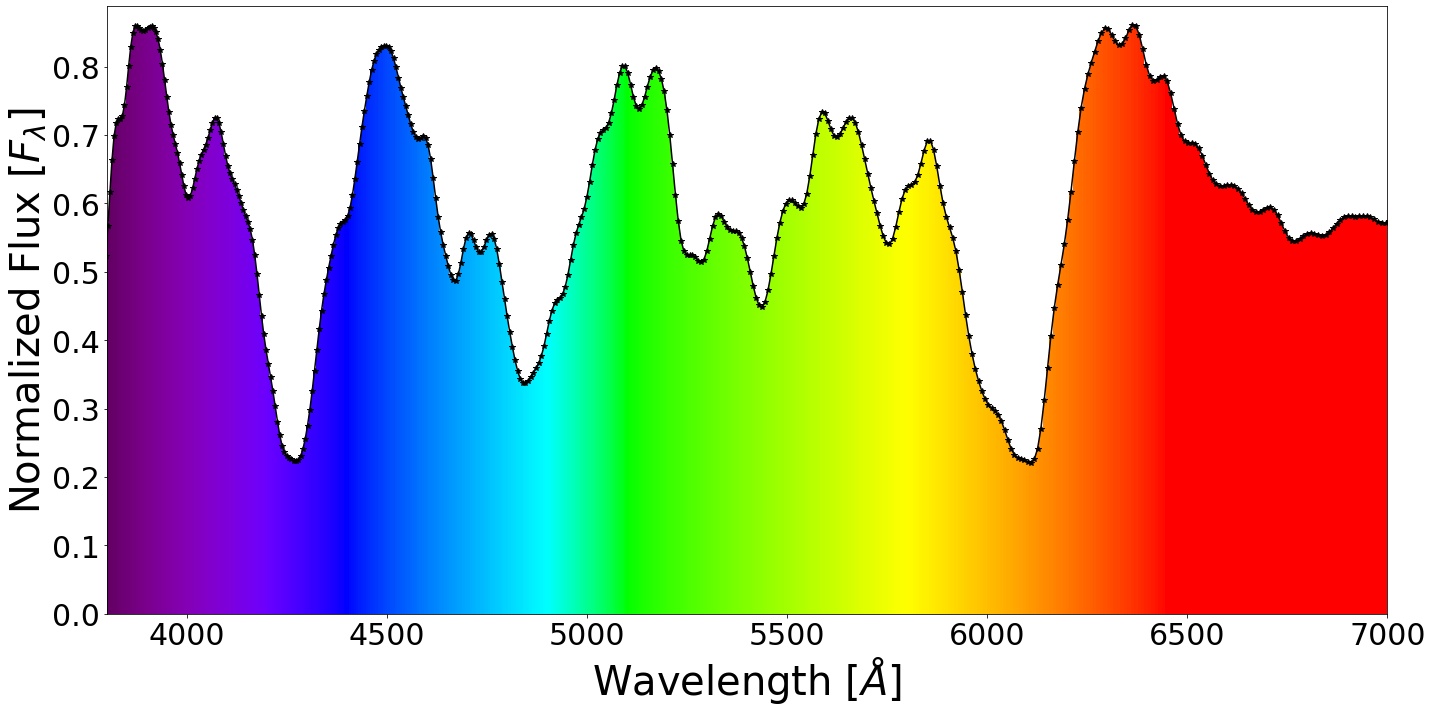

In [58]:
dplt.plotSpec(w_smoothed, f_smoothed - f_smoothed.min())